In [2]:
cd ..

/home/hjp/HJP/KUAICV/AbsoluteTrack


In [3]:
pwd

'/home/hjp/HJP/KUAICV/AbsoluteTrack'

In [4]:
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt



from lib.common.camera import Fisheye62CameraModel
from lib.common.hand import HandModel
from lib.tracker.tracking_result import SingleHandPose
from lib.tracker.video_pose_data import (
    HandPoseLabels,
    _load_hand_pose_labels,
    load_hand_model_from_dict,
    
)
from lib.tracker.perspective_crop import landmarks_from_hand_pose


HAND_CONNECTION_MAP = [
    [5, 6], [6, 7], [7, 0], # thumb
    [5, 8], [8, 9], [9, 10], [10, 2], # index
    [5, 11], [11, 12], [12, 13], [13, 2], # middle
    [5, 14], [14, 15], [15, 16], [16, 3], # ring
    [5, 17], [17, 18], [18, 19], [19, 4], # pinky
    [8, 11], [11, 14], [14, 17]
]
gt_handedness_color_map = {
    0: (0, 0, 255), # RED
    1: (0, 255, 0), # GREEN
}

SAMPLE_VID_PATH = "/home/hjp/HJP/KUAICV/AbsoluteTrack/sample_data/user05/recording_00.mp4"
SAMPLE_LABEL_PATH = "/home/hjp/HJP/KUAICV/AbsoluteTrack/sample_data/user05/user05/recording_00.json"
RESULT_FILE__PATH = "/home/hjp/HJP/KUAICV/AbsoluteTrack/sample_data/user05/user05/recording_00.npy"

cap = cv2.VideoCapture(SAMPLE_VID_PATH)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) // 4
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

data = _load_hand_pose_labels(SAMPLE_LABEL_PATH)

hand_model = data.hand_model

In [5]:
data.cameras

[Fisheye62CameraModel(636x480, f=(235.91973876953125, 235.8688507080078) c=(317.34576416015625, 240.08123779296875),
 Fisheye62CameraModel(636x480, f=(239.15582275390625, 238.99838256835938) c=(317.8420715332031, 239.2907257080078),
 Fisheye62CameraModel(636x480, f=(240.4190673828125, 239.9583282470703) c=(317.2039794921875, 240.38792419433594),
 Fisheye62CameraModel(636x480, f=(238.52735900878906, 238.29930114746094) c=(317.2388000488281, 239.65557861328125)]

In [6]:
data.camera_to_world_transforms.shape

(369, 4, 4, 4)

In [7]:
for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    gt_tracking = {}
    for hand_idx in range(0, 2):
        if data.hand_confidences[frame_idx, hand_idx] > 0:
            gt_tracking[hand_idx] = SingleHandPose(
                joint_angles=data.joint_angles[frame_idx, hand_idx],
                wrist_xform=data.wrist_transforms[frame_idx, hand_idx],
                hand_confidence=data.hand_confidences[frame_idx, hand_idx]
            )

In [8]:
print(frame_width, frame_height)

636 480


(480, 2544, 3)


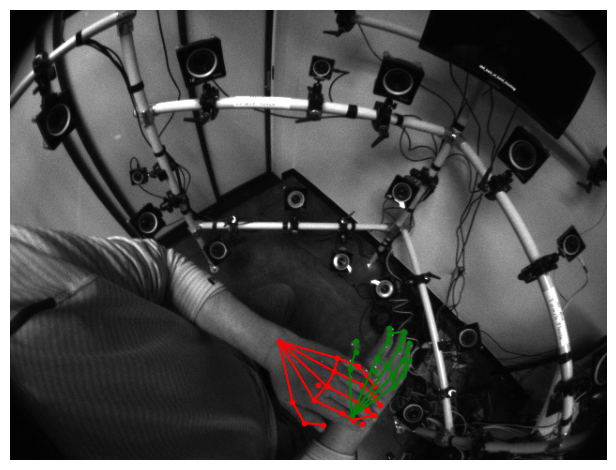

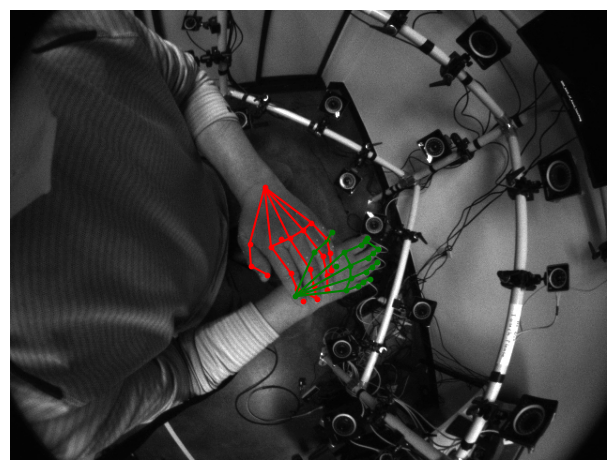

In [10]:
FRAME_IDX = 20

gt_handedness_color_map = {
    0: 'red',  # RED
    1: 'green',  # GREEN
}

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_IDX)
ret, frame_stereo = cap.read()

print(frame_stereo.shape)

cam_left = data.cameras[1].copy(
    camera_to_world_xf=data.camera_to_world_transforms[FRAME_IDX, 1]
)
cam_right = data.cameras[2].copy(
    camera_to_world_xf=data.camera_to_world_transforms[FRAME_IDX, 2]
)

frame_left_mono = frame_stereo[:, frame_width : 2*frame_width].copy()
frame_right_mono = frame_stereo[:, frame_width*2 : frame_width*3].copy()

gt_tracking = {}
for hand_idx in range(0, 2):
    if data.hand_confidences[FRAME_IDX, hand_idx] > 0:
        gt_tracking[hand_idx] = SingleHandPose(
            joint_angles=data.joint_angles[FRAME_IDX, hand_idx],
            wrist_xform=data.wrist_transforms[FRAME_IDX, hand_idx],
            hand_confidence=data.hand_confidences[FRAME_IDX, hand_idx]
        )

window_hand_pose_left = {}
for hand_idx in range(0, 2):
    keypoints_world = landmarks_from_hand_pose(
        hand_model,
        gt_tracking[hand_idx],
        hand_idx
    )
    window_hand_pose_left[hand_idx] = cam_left.eye_to_window(
        cam_left.world_to_eye(keypoints_world)
    )

window_hand_pose_right = {}
for hand_idx in range(0, 2):
    keypoints_world = landmarks_from_hand_pose(
        hand_model,
        gt_tracking[hand_idx],
        hand_idx
    )
    window_hand_pose_right[hand_idx] = cam_right.eye_to_window(
        cam_right.world_to_eye(keypoints_world)
    )

plt.imshow(frame_left_mono)
for hand_idx in range(0, 2):
    # plot points
    plt.scatter(
        window_hand_pose_left[hand_idx][:, 0],
        window_hand_pose_left[hand_idx][:, 1],
        marker='o',
        color=gt_handedness_color_map[hand_idx],
        s=10
    )
    # plot connections
    for connection in HAND_CONNECTION_MAP:
        plt.plot(
            window_hand_pose_left[hand_idx][connection, 0],
            window_hand_pose_left[hand_idx][connection, 1],
            color=gt_handedness_color_map[hand_idx],
        )
plt.axis('off')
plt.tight_layout()
plt.show()


plt.imshow(frame_right_mono)
for hand_idx in range(0, 2):
    # plot points
    plt.scatter(
        window_hand_pose_right[hand_idx][:, 0],
        window_hand_pose_right[hand_idx][:, 1],
        marker='o',
        color=gt_handedness_color_map[hand_idx],
        s=10
    )
    # plot connections
    for connection in HAND_CONNECTION_MAP:
        plt.plot(
            window_hand_pose_right[hand_idx][connection, 0],
            window_hand_pose_right[hand_idx][connection, 1],
            color=gt_handedness_color_map[hand_idx],
        )
plt.axis('off')
plt.tight_layout()
plt.show()